In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow import keras
from tensorflow.keras import layers, models

In [8]:
#Muat dataset
df = pd.read_csv('../Dataset/Infrared.csv')
print(df.to_string())
df.info()

      Gender    Age                          Ethnicity  T_atm  Humidity  Distance  T_offset1  Max1R13_1  Max1L13_1  aveAllR13_1  aveAllL13_1      T_RC1  T_RC_Dry1  T_RC_Wet1  T_RC_Max1      T_LC1  T_LC_Dry1  T_LC_Wet1  T_LC_Max1       RCC1       LCC1  canthiMax1  canthi4Max1    T_FHCC1    T_FHRC1    T_FHLC1    T_FHBC1    T_FHTC1  T_FH_Max1  T_FHC_Max1     T_Max1      T_OR1  T_OR_Max1  aveOralM
0       Male  41-50                              White   24.0      28.0      0.80   0.702500  35.030000  35.377500    34.400000    34.917500  34.985000  34.985000  34.762500  35.032500  35.337500  35.337500  34.485000  35.377500  34.785000  34.465000   35.377500    35.337500  33.577500  33.477500  33.372500  33.492500  33.002500  34.530000   34.007500  35.692500  35.635000  35.652500     36.59
1     Female  31-40          Black or African-American   24.0      26.0      0.80   0.780000  34.550000  34.520000    33.930000    34.225000  34.710000  34.632500  34.640000  34.742500  34.560000  34.537500

In [9]:
#Cek data yang hilang
df.isnull().sum()

Gender         0
Age            0
Ethnicity      0
T_atm          0
Humidity       0
Distance       2
T_offset1      0
Max1R13_1      0
Max1L13_1      0
aveAllR13_1    0
aveAllL13_1    0
T_RC1          0
T_RC_Dry1      0
T_RC_Wet1      0
T_RC_Max1      0
T_LC1          0
T_LC_Dry1      0
T_LC_Wet1      0
T_LC_Max1      0
RCC1           0
LCC1           0
canthiMax1     0
canthi4Max1    0
T_FHCC1        0
T_FHRC1        0
T_FHLC1        0
T_FHBC1        0
T_FHTC1        0
T_FH_Max1      0
T_FHC_Max1     0
T_Max1         0
T_OR1          0
T_OR_Max1      0
aveOralM       0
dtype: int64

In [14]:
#Memisahkan kolom aveOralM
x = df.drop(columns=['aveOralM'])
y = df['aveOralM']

In [15]:
#Pilih kolom dengan tipe data numerik dan kategorikal
numeric_dtypes = x.select_dtypes(include=['number']).columns
categorical_dtypes = x.select_dtypes(exclude=['number']).columns

In [16]:
#Mengisi data yang hilang dan melakukan scaling
numeric_trf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [17]:
#Mengisi data yang hilang dan melakukan encoding
categorical_trf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [18]:
#Menggabungkan data yang telah diisi dan diubah
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_trf, numeric_dtypes),
    ('cat', categorical_trf, categorical_dtypes)
])

In [22]:
#Bagi data menjadi data latih dan data uji
x_processed = preprocessor.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_processed, y, test_size=0.2, random_state=42)
print(f'x_train: {x_train.shape}')
print(f'x_test: {x_test.shape}')

x_train: (816, 46)
x_test: (204, 46)


In [23]:
#Konversi data ke tensor PyTorch
x_train_torch = torch.tensor(x_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
x_test_torch = torch.tensor(x_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [24]:
#Model PyTorch
class PyTorchModel(nn.Module):
    def __init__(self, input_dim):
        super(PyTorchModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.output(x)
        return x 

In [ ]:
#Melatih model PyTorch
input_dim = x_train.shape[1]
pytorch_model = PyTorchModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)

X_train_torch = torch.tensor(x_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_torch = torch.tensor(x_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

losses = []
for epoch in range(1000):
    pytorch_model.train()
    optimizer.zero_grad()
    outputs = pytorch_model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

In [51]:
#Evaluasi model PyTorch
pytorch_model.eval()
with torch.no_grad():
    y_pred_torch = pytorch_model(X_test_torch)

mse_torch = mean_squared_error(y_test, y_pred_torch.numpy())
rmse_torch = np.sqrt(mse_torch)
r2_torch = r2_score(y_test, y_pred_torch.numpy())

print(f'PyTorch Model')
print(f'MSE: {mse_torch}')
print(f'RMSE: {rmse_torch}')
print(f'R2 Score: {r2_torch}')

PyTorch Model
MSE: 0.1405553767654173
RMSE: 0.37490715752759013
R2 Score: 0.33250723659707515


In [52]:
# Model TensorFlow
tf_model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

In [53]:
# Compile model
tf_model.compile(optimizer='adam', loss='mse')
history = tf_model.fit(x_train, y_train, epochs=500, batch_size=32, verbose=0)

In [54]:
#Evaluasi model TensorFlow
y_pred_tf = tf_model.predict(x_test)

mse_tf = mean_squared_error(y_test, y_pred_tf)
rmse_tf = np.sqrt(mse_tf)
r2_tf = r2_score(y_test, y_pred_tf)

print(f'TensorFlow Model')
print(f'MSE: {mse_tf}')
print(f'RMSE: {rmse_tf}')
print(f'R2 Score: {r2_tf}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
TensorFlow Model
MSE: 0.26892692450987843
RMSE: 0.5185816469080625
R2 Score: -0.2771249320055533


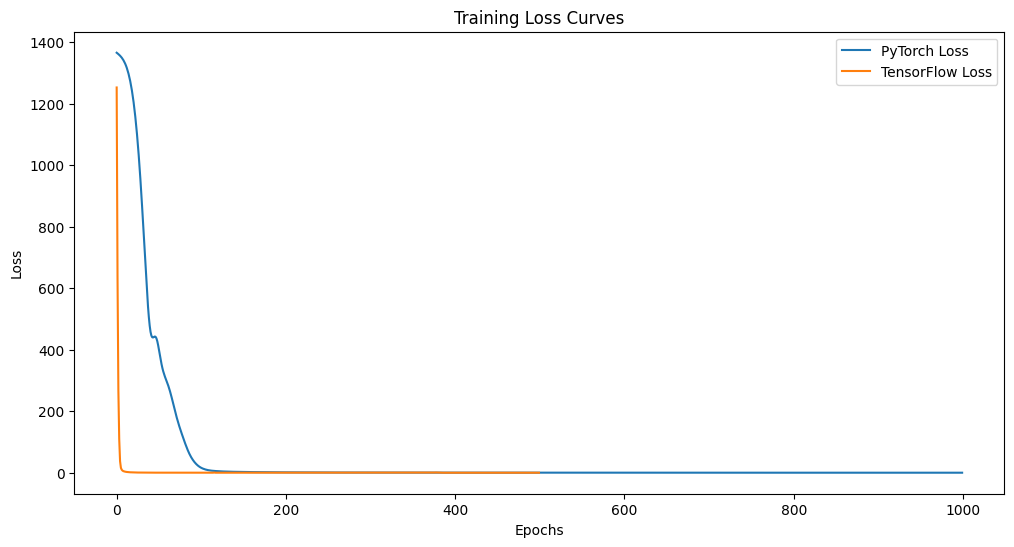

In [55]:
#Visualisasi kurva loss
plt.figure(figsize=(12, 6))
plt.plot(losses, label='PyTorch Loss')
plt.plot(history.history['loss'], label='TensorFlow Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curves')
plt.show()

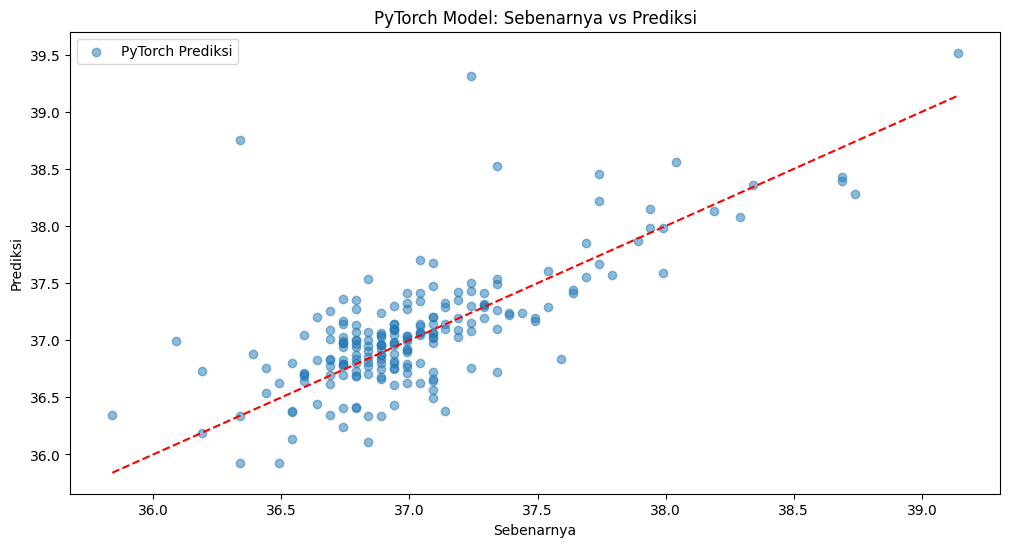

In [57]:
#Visualisasi aktual vs prediksi PyTorch
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_torch.numpy(), label='PyTorch Prediksi', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Sebenarnya')
plt.ylabel('Prediksi')
plt.legend()
plt.title('PyTorch Model: Sebenarnya vs Prediksi')
plt.show()

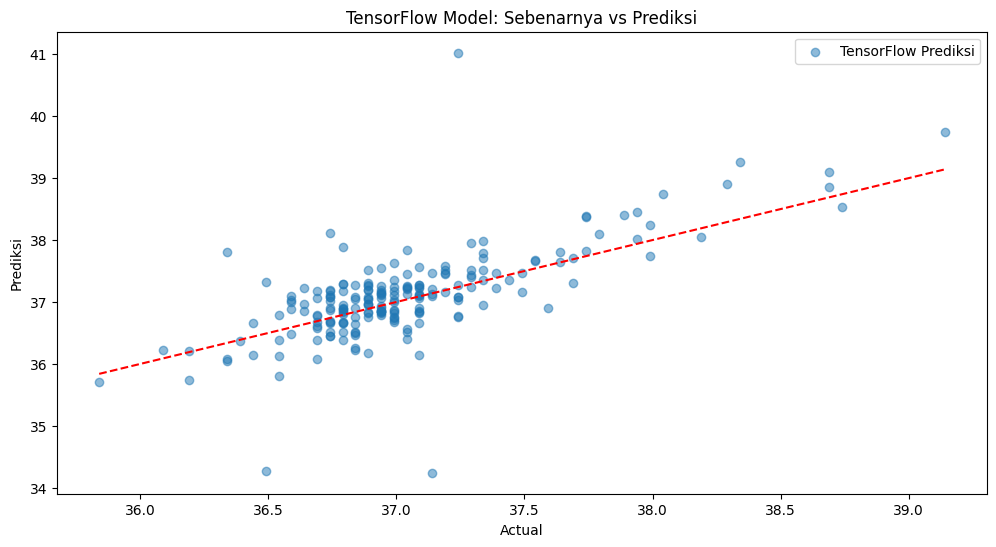

In [58]:
#Visualisasi aktual vs prediksi TensorFlow
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_tf, label='TensorFlow Prediksi', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Prediksi')
plt.legend()
plt.title('TensorFlow Model: Sebenarnya vs Prediksi')
plt.show()

In [67]:
#Contoh untuk prediksi
sample_idx = np.random.randint(0, len(x_test))
sample_actual = y_test.iloc[sample_idx]
sample_input = torch.tensor(x_test[sample_idx].reshape(1, -1), dtype=torch.float32)

with torch.no_grad():
    sample_pred_torch = pytorch_model(sample_input).item()
sample_pred_tf = tf_model.predict(x_test[sample_idx].reshape(1, -1))[0][0]

print(f'Nilai sebenarnya: {sample_actual:.4f}')
print(f'Prediksi PyTorch: {sample_pred_torch:.4f}')
print(f'Prediksi TensorFlow: {sample_pred_tf:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Nilai sebenarnya: 37.3900
Prediksi PyTorch: 37.2248
Prediksi TensorFlow: 37.2264


# Penjelasan Persamaan Matematika dalam Model

## 1. Mean Squared Error (MSE)  
Digunakan sebagai fungsi loss dalam model PyTorch dan TensorFlow:

\[
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
\]

di mana:  
- \( y_i \) adalah nilai aktual,  
- \( \hat{y}_i \) adalah nilai prediksi,  
- \( n \) adalah jumlah sampel.  

## 2. Root Mean Squared Error (RMSE)  
Dihitung dari MSE untuk mendapatkan nilai kesalahan dalam skala asli:

\[
RMSE = \sqrt{MSE}
\]

## 3. R-Squared Score (\( R^2 \))  
Digunakan untuk menilai seberapa baik model menjelaskan variabilitas data:

\[
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
\]

di mana \( \bar{y} \) adalah rata-rata dari nilai aktual.

## 4. Transformasi Data  
- **StandardScaler:** Standarisasi fitur menggunakan rumus:

  \[
  x' = \frac{x - \mu}{\sigma}
  \]

  di mana \( \mu \) adalah rata-rata dan \( \sigma \) adalah standar deviasi.  
- **One-Hot Encoding:** Mengonversi data kategori menjadi bentuk vektor biner.

## 5. Propagasi Maju dalam Neural Network  
- Setiap lapisan dalam PyTorch dan TensorFlow melakukan operasi linear:

  \[
  z = W \cdot x + b
  \]

- Aktivasi ReLU diterapkan:

  \[
  f(z) = \max(0, z)
  \]
